In [46]:
import pickle

with open("../../results/simulation_result.pkl", "rb") as f:
    result = pickle.load(f)
    print("data length:",len(result))

data length: 2000


In [47]:
import pandas as pd
import numpy as np

def extract_flux_matrix_for_targets(result, df_medium, target_met_names):
    """ 
    Parameters:
        result: dict,  result[env_idx][model_id] = (biomass, fluxes)
        df_medium: comtain flux index and met_id 
        target_met_names: list of str,  ID： "cpd00029_e0"
    """
    # build flux_i → met_id 
    flux_col_mapping = {
        f"flux_{i}": df_medium.iloc[i]["met_id"]
        for i in range(len(df_medium))
    }

    # met_id → flux_i
    met_to_flux_idx = {
        met_id: flux_i for flux_i, met_id in flux_col_mapping.items()
    }
    selected_met_ids = [m for m in target_met_names if m in met_to_flux_idx]
    selected_flux_indices = {
        m: int(met_to_flux_idx[m].split("_")[1]) for m in selected_met_ids
    }
    rows = []
    for env_idx, model_results in result.items():
        for model_id, (biomass, fluxes) in model_results.items():
            row = {
                "env_idx": env_idx,
                "model_id": model_id,
                "biomass": biomass
            }
            # add target fluxes
            for met_id, idx in selected_flux_indices.items():
                if idx < len(fluxes):
                    row[met_id] = float(fluxes[idx])
                else:
                    row[met_id] = np.nan  
            rows.append(row)

    return pd.DataFrame(rows)

# load medium
medium_file = "../../models/group_medium_exchanges.tsv"
df_medium = pd.read_csv(medium_file, sep="\t")

# target metabolites
target_met_names = ["cpd00067_e0",
                    "cpd00029_e0", 
                    "cpd00047_e0", 
                    "cpd00141_e0"]

data = extract_flux_matrix_for_targets(result, df_medium, target_met_names)
data["MAG"] = data["model_id"].str.extract(r"(MAG\d+)")
data

,env_idx,model_id,biomass,cpd00067_e0,cpd00029_e0,cpd00047_e0,cpd00141_e0,MAG
0,1,MAG001_gapfilled_noO2,4.637470,-12.202743,0.254851,0.197452,0.0,MAG001
1,1,MAG002_gapfilled_noO2,11.890949,433.206596,124.256971,-0.296115,0.0,MAG002
2,1,MAG003_gapfilled_noO2,4.637470,-12.202743,0.077476,0.000000,0.0,MAG003
3,1,MAG004_gapfilled_noO2,4.637470,-12.202743,0.000000,-1.663887,0.0,MAG004
4,1,MAG005_gapfilled_noO2,164.078598,-12.202743,287.833036,0.000000,0.0,MAG005
...,...,...,...,...,...,...,...,...
479995,2000,MAG236_gapfilled_noO2,43.110780,75.881765,13.707561,0.000000,0.0,MAG236
479996,2000,MAG237_gapfilled_noO2,16.813204,4.986770,0.000000,0.000000,0.0,MAG237
479997,2000,MAG238_gapfilled_noO2,43.110780,1000.000000,344.694146,0.000000,0.0,MAG238
479998,2000,MAG239_gapfilled_noO2,16.813204,-3.272377,0.000000,0.000000,0.0,MAG239


In [48]:
# load genome coverage data
file_path = "../../data/genome/median_coverage_genomes.parquet"
abundance_df = pd.read_parquet(file_path)

# sample →  group
sample_to_group = {
    "R1J142A": "Saline_Anode",
    "R2J142A": "Saline_Anode",
    "R3J142A": "Saline_Anode",
    "R4J147A": "Non_saline_Anode",
    "R5J141A": "Non_saline_Anode",
    "R6J143A": "Non_saline_Anode",

    "R4J147C": "Non_saline_Cathode",
    "R5J141C": "Non_saline_Cathode",
    "R6J143C": "Non_saline_Cathode",

    "Sg1AJ36C": "Saline_Cathode",
    "Sg1BJ36C": "Saline_Cathode",
    "Sg1CJ36C": "Saline_Cathode",

    "NSg1AJ41C": "Non_saline_Cathode",
    "NSg1BJ41C": "Non_saline_Cathode",
    "NSg1CJ41C": "Non_saline_Cathode"
}

abundance_df["Group"] = abundance_df["index"].map(sample_to_group)
abundance_df

Genome,index,MAG001,MAG002,MAG003,MAG004,MAG005,MAG006,MAG007,MAG008,MAG009,...,MAG232,MAG233,MAG234,MAG235,MAG236,MAG237,MAG238,MAG239,MAG240,Group
0,NSg1AJ41C,144.805,106.79,23.15,97.310,80.285,24.04,23.51,46.90,116.28,...,0.070,0.360,0.00,0.13,0.00,0.000,1.34,0.000,0.00,Non_saline_Cathode
1,NSg1BJ41C,0.000,123.42,11.31,102.315,10.950,26.28,24.30,54.29,68.63,...,0.070,0.370,0.00,0.14,0.00,0.000,1.37,0.000,0.00,Non_saline_Cathode
2,NSg1CJ41C,0.000,71.37,0.00,0.000,0.640,22.18,28.28,41.80,39.50,...,0.090,0.490,0.00,0.11,0.00,0.000,1.26,0.000,0.00,Non_saline_Cathode
3,R1J142A,0.000,0.00,0.00,0.000,0.090,0.00,0.00,0.00,0.00,...,1.980,0.000,0.00,0.00,0.00,0.000,0.00,0.000,0.00,Saline_Anode
4,R2J142A,0.000,0.00,0.00,0.000,0.000,0.00,0.00,0.00,0.00,...,1.020,0.000,0.00,0.00,0.00,0.000,0.00,0.000,0.00,Saline_Anode
5,R3J142A,0.000,0.00,0.00,0.000,0.000,0.00,0.00,0.00,0.00,...,14.980,0.000,0.00,0.00,1.91,0.000,0.00,0.000,0.00,Saline_Anode
6,R4J147A,0.000,23.51,0.00,0.000,0.000,0.00,0.00,0.52,0.10,...,0.000,2.930,0.00,0.00,0.00,0.000,0.26,0.000,0.00,Non_saline_Anode
7,R4J147C,0.000,3.82,0.00,7.750,0.270,0.00,0.60,39.60,0.00,...,0.120,0.000,0.00,0.27,0.00,0.000,1.01,0.000,0.00,Non_saline_Cathode
8,R5J141A,0.000,21.74,0.19,0.000,0.000,0.00,0.02,0.61,0.00,...,0.000,0.270,0.00,0.00,0.00,0.000,0.21,0.000,0.00,Non_saline_Anode
9,R5J141C,0.000,0.83,0.00,1.790,4.460,0.00,1.06,39.81,0.00,...,0.040,0.000,0.00,0.32,0.00,0.000,1.21,0.000,0.00,Non_saline_Cathode


In [49]:
# build select dict
mag_cols = abundance_df.columns.difference(["Group"])
abundance_df[mag_cols] = abundance_df[mag_cols].apply(pd.to_numeric, errors="coerce")
# Calculate mean abundance for each group
group_mag_mean = abundance_df.groupby("Group")[mag_cols].mean().T  

selected_mag_by_group = {
    group: group_mag_mean.index[group_mag_mean[group] > 0].tolist()
    for group in group_mag_mean.columns
}
for group, mag_list in selected_mag_by_group.items():
    print(f"{group}: {len(mag_list)} MAGs")

Non_saline_Anode: 115 MAGs
Non_saline_Cathode: 125 MAGs
Saline_Anode: 84 MAGs
Saline_Cathode: 69 MAGs


In [50]:
# Create subsets of data for each group based on selected MAGs
fba_subsets_by_group = {}
for group, mag_list in selected_mag_by_group.items():
    fba_subsets_by_group[group] = data[data["MAG"].isin(mag_list)].copy()

saline_anode_df = fba_subsets_by_group["Saline_Anode"]
nonsaline_anode_df = fba_subsets_by_group["Non_saline_Anode"]
saline_cathode_df = fba_subsets_by_group["Saline_Cathode"]
nonsaline_cathode_df = fba_subsets_by_group["Non_saline_Cathode"]


/var/folders/6w/knrbtrj125ggkrx091kd2g840000gn/T/ipykernel_14164/2507193767.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


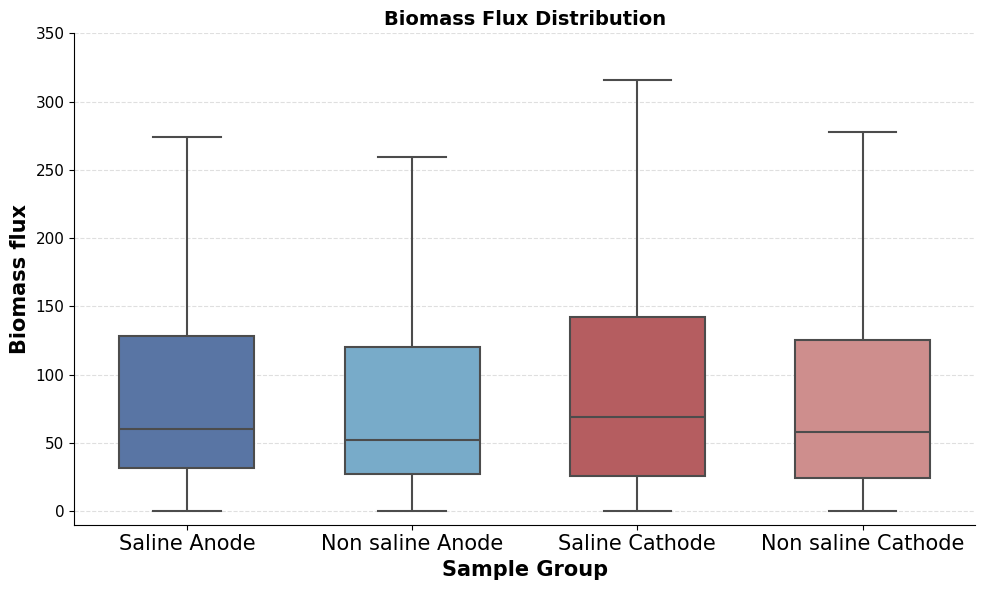

In [79]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# biomass boxplot dataset
df_all = pd.concat([
    saline_anode_df.assign(Group="Saline_Anode"),
    nonsaline_anode_df.assign(Group="Non_saline_Anode"),
    saline_cathode_df.assign(Group="Saline_Cathode"),
    nonsaline_cathode_df.assign(Group="Non_saline_Cathode"),
])
df_all["Group"] = df_all["Group"].str.replace("_", " ")


palette = {
    "Saline Anode": "#4C72B0",        
    "Non saline Anode": "#6BAED6",    
    "Saline Cathode": "#C44E52",      
    "Non saline Cathode": "#D98482"  
}

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_all,
    x="Group",
    y="biomass",
    width=0.6,                 # 缩小箱子宽度
    linewidth=1.5,             # 线条粗细
    showfliers=False,
    palette=palette                
)
plt.ylim(-10, 350)  
plt.title("Biomass Flux Distribution", fontsize=14, fontweight='bold')

plt.xlabel("Sample Group", fontsize=15, fontweight='bold')
plt.ylabel("Biomass flux", fontsize=15, fontweight='bold')
plt.xticks(fontsize=15)
plt.yticks(fontsize=11)
plt.grid(axis="y", linestyle="--", alpha=0.4)

# 去除顶部和右侧边框
sns.despine()

plt.tight_layout()
plt.show()

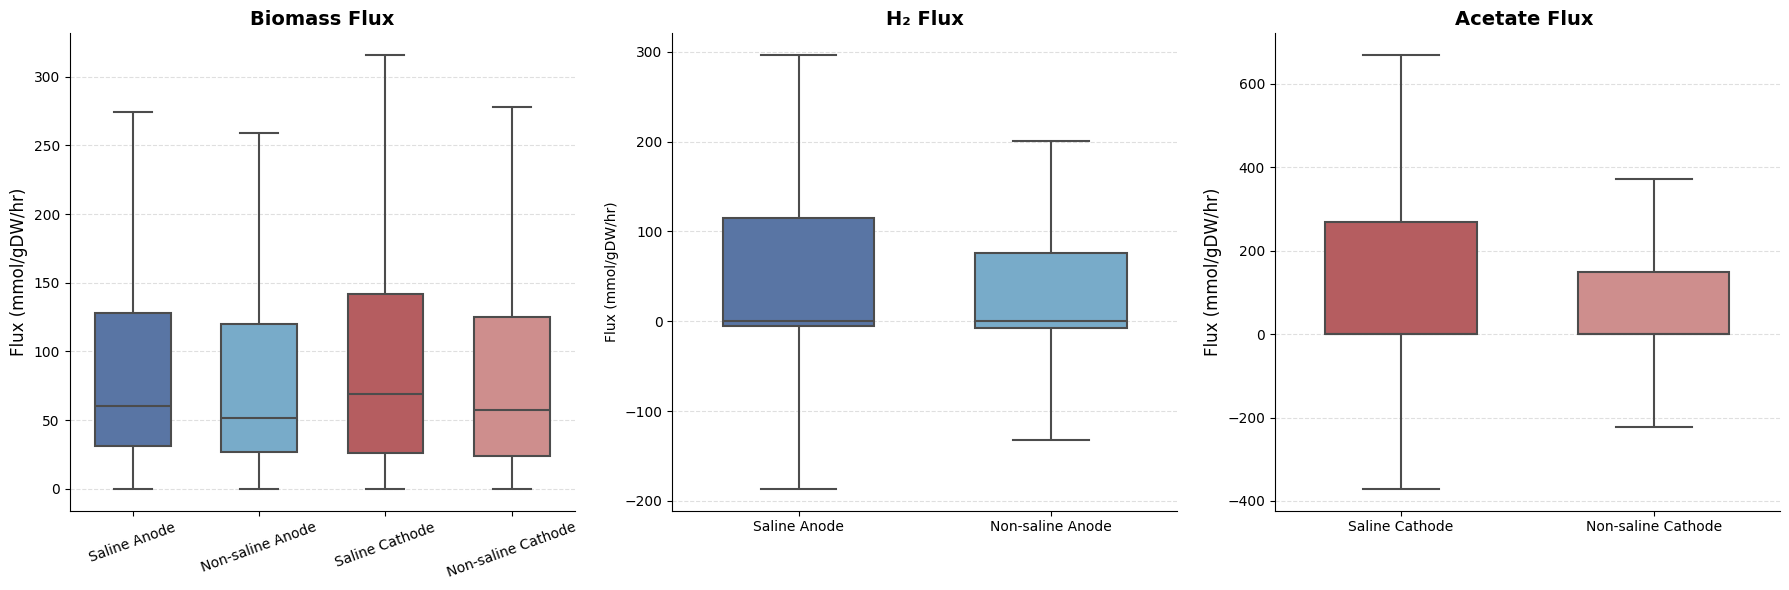

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# merge data
df_all = pd.concat([
    saline_anode_df.assign(Group="Saline Anode"),
    nonsaline_anode_df.assign(Group="Non-saline Anode"),
    saline_cathode_df.assign(Group="Saline Cathode"),
    nonsaline_cathode_df.assign(Group="Non-saline Cathode"),
])

# color palette
group_palette = {
    "Saline Anode": "#4C72B0",          
    "Non-saline Anode": "#6BAED6",      
    "Saline Cathode": "#C44E52",        
    "Non-saline Cathode": "#D98482",    
}

# subplot 
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

# plot1：Biomass 
sns.boxplot(
    data=df_all,
    x="Group",
    y="biomass",
    hue="Group",
    palette=group_palette,
    width=0.6,
    linewidth=1.5,
    showfliers=False,
    dodge=False,
    legend=False,
    ax=axes[0]
)
axes[0].set_title("Biomass Flux", fontsize=14, fontweight='bold')
axes[0].set_xlabel("")
axes[0].set_ylabel("Flux (mmol/gDW/hr)", fontsize=12)
axes[0].tick_params(axis='x')

# plot2：H₂ flux
anode_df = df_all[df_all["Group"].isin(["Saline Anode", "Non-saline Anode"])]
sns.boxplot(
    data=anode_df,
    x="Group",
    y="cpd00067_e0",
    hue="Group",
    palette=group_palette,
    width=0.6,
    linewidth=1.5,
    showfliers=False,
    ax=axes[1]
)
axes[1].set_title("H₂ Flux", fontsize=14, fontweight='bold')
axes[1].set_xlabel("")
axes[1].set_ylabel("Flux (mmol/gDW/hr)")
axes[1].tick_params(axis='x')

# plot 3：Acetate flux
cathode_df = df_all[df_all["Group"].isin(["Saline Cathode", "Non-saline Cathode"])]
sns.boxplot(
    data=cathode_df,
    x="Group",
    y="cpd00029_e0",
    hue="Group",
    palette=group_palette,
    width=0.6,
    linewidth=1.5,
    showfliers=False,
    ax=axes[2]
)
axes[2].set_title("Acetate Flux ", fontsize=14, fontweight='bold')
axes[2].set_xlabel("")
axes[2].set_ylabel("Flux (mmol/gDW/hr)", fontsize=12)
axes[2].tick_params(axis='x')

# 
for ax in axes:
    ax.grid(axis="y", linestyle="--", alpha=0.4)
    sns.despine(ax=ax)

plt.tight_layout()
plt.show()


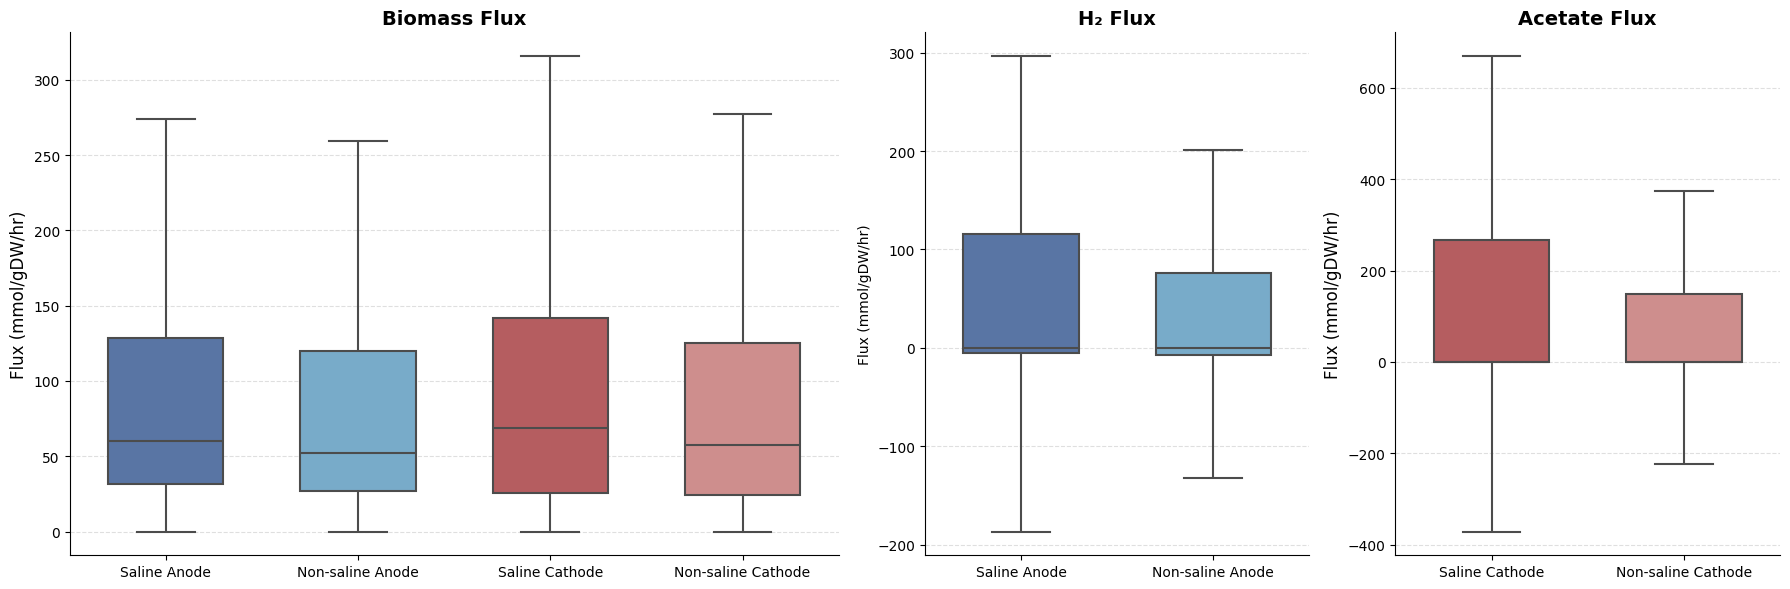

In [98]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec

# merge data
df_all = pd.concat([
    saline_anode_df.assign(Group="Saline Anode"),
    nonsaline_anode_df.assign(Group="Non-saline Anode"),
    saline_cathode_df.assign(Group="Saline Cathode"),
    nonsaline_cathode_df.assign(Group="Non-saline Cathode"),
])

# color palette
group_palette = {
    "Saline Anode": "#4C72B0",          
    "Non-saline Anode": "#6BAED6",      
    "Saline Cathode": "#C44E52",        
    "Non-saline Cathode": "#D98482",    
}

# define subplots with different widths
fig = plt.figure(figsize=(18, 6))
gs = gridspec.GridSpec(1, 3, width_ratios=[2, 1, 1])  # Biomass 2x宽

# ---- Biomass Flux ----
ax1 = fig.add_subplot(gs[0])
sns.boxplot(
    data=df_all,
    x="Group",
    y="biomass",
    hue="Group",
    palette=group_palette,
    width=0.6,
    linewidth=1.5,
    showfliers=False,
    dodge=False,
    legend=False,
    ax=ax1
)
ax1.set_title("Biomass Flux", fontsize=14, fontweight='bold')
ax1.set_xlabel("")
ax1.set_ylabel("Flux (mmol/gDW/hr)", fontsize=12)
ax1.tick_params(axis='x')
ax1.grid(axis="y", linestyle="--", alpha=0.4)
sns.despine(ax=ax1)

# ---- H2 Flux ----
anode_df = df_all[df_all["Group"].isin(["Saline Anode", "Non-saline Anode"])]
ax2 = fig.add_subplot(gs[1])
sns.boxplot(
    data=anode_df,
    x="Group",
    y="cpd00067_e0",
    hue="Group",
    palette=group_palette,
    width=0.6,
    linewidth=1.5,
    showfliers=False,
    dodge=False,
    legend=False,
    ax=ax2
)
ax2.set_title("H₂ Flux", fontsize=14, fontweight='bold')
ax2.set_xlabel("")
ax2.set_ylabel("Flux (mmol/gDW/hr)")
ax2.tick_params(axis='x')
ax2.grid(axis="y", linestyle="--", alpha=0.4)
sns.despine(ax=ax2)

# ---- Acetate Flux ----
cathode_df = df_all[df_all["Group"].isin(["Saline Cathode", "Non-saline Cathode"])]
ax3 = fig.add_subplot(gs[2])
sns.boxplot(
    data=cathode_df,
    x="Group",
    y="cpd00029_e0",
    hue="Group",
    palette=group_palette,
    width=0.6,
    linewidth=1.5,
    showfliers=False,
    dodge=False,
    legend=False,
    ax=ax3
)
ax3.set_title("Acetate Flux", fontsize=14, fontweight='bold')
ax3.set_xlabel("")
ax3.set_ylabel("Flux (mmol/gDW/hr)", fontsize=12)
ax3.tick_params(axis='x')
ax3.grid(axis="y", linestyle="--", alpha=0.4)
sns.despine(ax=ax3)

# layout
plt.tight_layout()
plt.show()
